In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from cycler import cycler

In [2]:
# 1. Read dataset from current directory
file_path = 'merged_test_dataset.csv'
merged_df = pd.read_csv(file_path)

In [3]:
# 2. Basic data checking
def check_data(df):
    print("\n--- Basic Data Info ---")
    print(df.info())
    print("\n--- Missing Value Stats ---")
    print(df.isnull().sum())
    print("\n--- Descriptive Statistics ---")
    print(df.describe())

check_data(merged_df)


--- Basic Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55246 entries, 0 to 55245
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TIME         55246 non-null  float64
 1   P1           55246 non-null  float64
 2   P2           55246 non-null  float64
 3   P3           55246 non-null  float64
 4   P4           55246 non-null  float64
 5   P5           55246 non-null  float64
 6   P6           55246 non-null  float64
 7   P7           55246 non-null  float64
 8   Case#        55246 non-null  int64  
 9   Spacecraft#  55246 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 4.2 MB
None

--- Missing Value Stats ---
TIME           0
P1             0
P2             0
P3             0
P4             0
P5             0
P6             0
P7             0
Case#          0
Spacecraft#    0
dtype: int64

--- Descriptive Statistics ---
               TIME            P1            P2            P3  

In [4]:
# 3. Statistical feature extraction (mean, std, min, max, median for P1-P7)
pressure_cols = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
stats_features = merged_df.groupby("Case#")[pressure_cols].agg(['mean', 'std', 'min', 'max', 'median'])
stats_features.columns = ["_".join(col) for col in stats_features.columns]
stats_features.reset_index(inplace=True)

In [5]:
# 4. Time-domain features: pressure change rate
for col in pressure_cols:
    merged_df[f"{col}_diff"] = merged_df.groupby("Case#")[col].diff().fillna(0)

time_series_cols = [f"{col}_diff" for col in pressure_cols]
time_series_features = merged_df.groupby("Case#")[time_series_cols].agg(['mean', 'std'])
time_series_features.columns = ["_".join(col) for col in time_series_features.columns]
time_series_features.reset_index(inplace=True)

In [6]:
# 5. Frequency-domain features (FFT)
def extract_fft_features(df, col):
    fft_vals = np.abs(fft(df[col].values))
    return pd.Series({
        f"{col}_fft_mean": np.mean(fft_vals),
        f"{col}_fft_max": np.max(fft_vals),
        f"{col}_fft_std": np.std(fft_vals)
    })

fft_features = merged_df.groupby("Case#").apply(lambda x: extract_fft_features(x, "P1"))
fft_features.reset_index(inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30164\1560563432.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fft_features = merged_df.groupby("Case#").apply(lambda x: extract_fft_features(x, "P1"))


In [7]:
# 6. Compute mean P1 value for each case
case_p1_mean = merged_df.groupby("Case#")["P1"].mean().reset_index()
case_p1_mean.columns = ["Case#", "P1_Mean"]
print("\n--- Mean P1 Value by Case ---")
print(case_p1_mean)


--- Mean P1 Value by Case ---
    Case#   P1_Mean
0     178  1.984422
1     179  1.984932
2     180  1.984972
3     181  1.985002
4     182  1.984954
5     183  1.984890
6     184  2.976179
7     185  1.984882
8     186  1.984192
9     187  1.984911
10    188  1.984494
11    189  1.984971
12    190  1.984945
13    191  1.985013
14    192  2.978119
15    193  1.984388
16    194  1.984877
17    195  1.984884
18    196  1.984876
19    197  1.985009
20    198  1.985037
21    199  1.984946
22    200  2.976179
23    201  1.984791
24    202  1.984803
25    203  1.984923
26    204  1.984459
27    205  1.984957
28    206  1.984652
29    207  2.978089
30    208  1.984845
31    209  1.985203
32    210  1.984873
33    211  1.984754
34    212  1.985226
35    213  1.985047
36    214  1.984538
37    215  1.984965
38    216  1.984238
39    217  1.984875
40    218  2.976114
41    219  1.984404
42    220  1.984997
43    221  1.984572
44    222  2.977766
45    223  1.984994


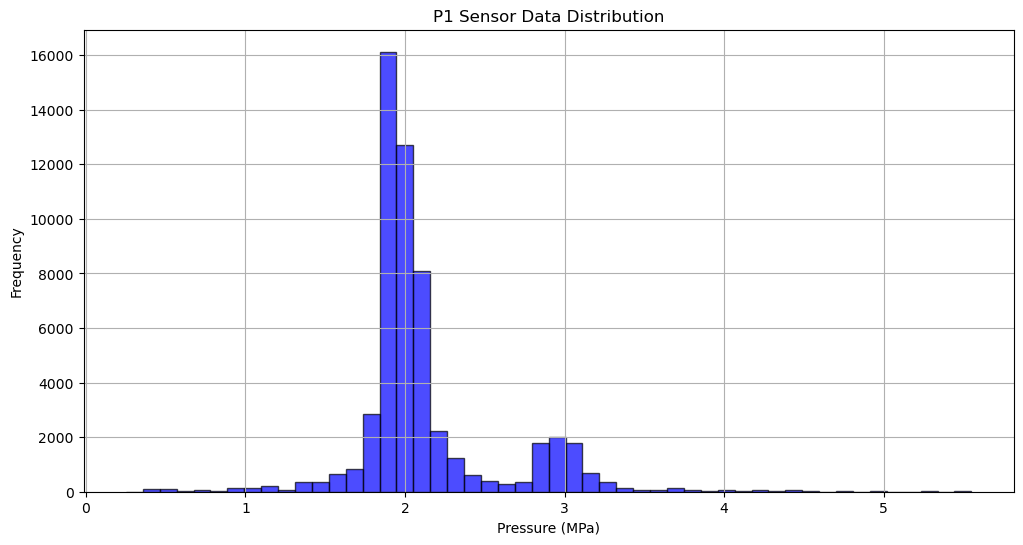

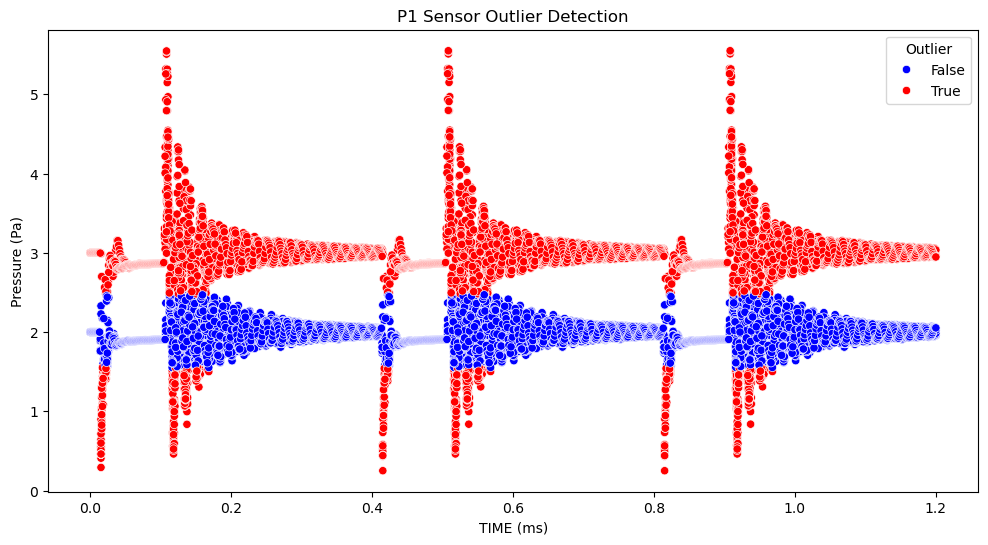

In [8]:
# 7. Visual Analysis

# P1 pressure distribution histogram
plt.figure(figsize=(12, 6))
merged_df["P1"].hist(bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("P1 Sensor Data Distribution")
plt.xlabel("Pressure (MPa)")
plt.ylabel("Frequency")
plt.show()

# Outlier detection using IQR
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (data[column] < lower) | (data[column] > upper)

merged_df["Outlier"] = detect_outliers(merged_df, "P1")

# Scatter plot with outliers marked
plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_df["TIME"], y=merged_df["P1"], hue=merged_df["Outlier"], palette={False: 'blue', True: 'red'})
plt.title("P1 Sensor Outlier Detection")
plt.xlabel("TIME (ms)")
plt.ylabel("Pressure (Pa)")
plt.show()

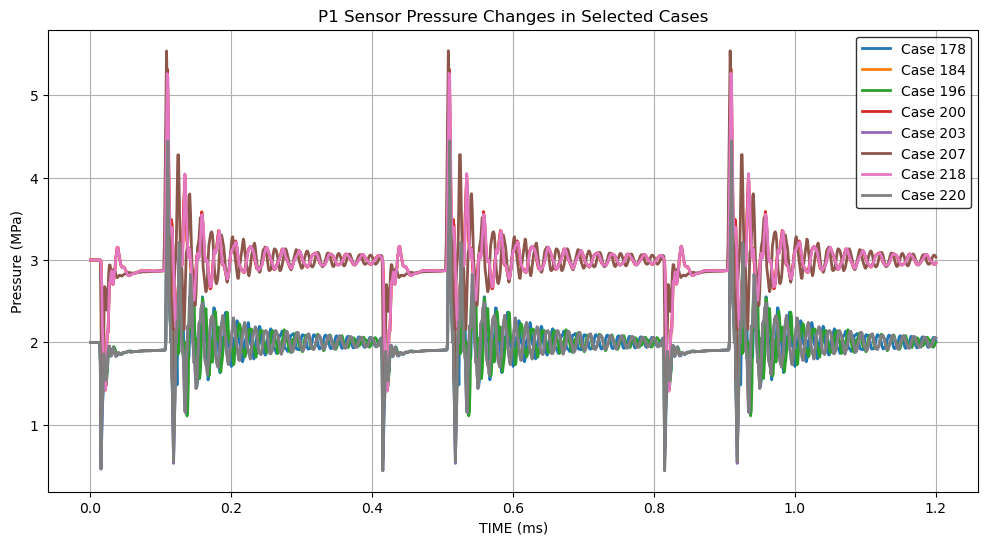

In [9]:
# 8. Plot P1 sensor pressure for selected cases
selected_cases = [178, 184, 196, 200, 203, 207, 218, 220]

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab10.colors)
plt.rcParams.update({
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.labelcolor': 'black',
    'text.color': 'black'
})

plt.figure(figsize=(12, 6))
for case in selected_cases:
    case_df = merged_df[merged_df["Case#"] == case]
    plt.plot(case_df["TIME"], case_df["P1"], label=f"Case {case}", linewidth=2)

plt.title("P1 Sensor Pressure Changes in Selected Cases")
plt.xlabel("TIME (ms)")
plt.ylabel("Pressure (MPa)")
plt.legend(edgecolor='black')
plt.grid(True)
plt.show()